In [54]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import numpy as np
from functools import reduce

In [55]:
df_uyc = pd.read_csv("data/Usuariosyconsumodeelectricidadpormunicipio_clean.csv", dtype={
    'Cve_Edo': 'string',
    'Cve_Inegi': 'string',
    'Cve_Mun': 'string',
    'Estado': 'string',
    'Municipio': 'string',
    'Tarifa': 'string',
    'Periodo': 'int64',
    'Usuarios': 'int64',
    'Consumo': 'float64',
    'ISO': 'string'
})
df_uyc.head()

,Cve_Edo,Cve_Inegi,Cve_Mun,Estado,Municipio,Tarifa,Periodo,Usuarios,Consumo,ISO
0,1,01,001,Aguascalientes,Aguascalientes,01,2010,231727,281228528.0,MX-AGU
1,1,01,001,Aguascalientes,Aguascalientes,1A,2010,0,0.0,MX-AGU
2,1,01,001,Aguascalientes,Aguascalientes,1B,2010,0,0.0,MX-AGU
3,1,01,001,Aguascalientes,Aguascalientes,1C,2010,0,0.0,MX-AGU
4,1,01,001,Aguascalientes,Aguascalientes,1D,2010,0,0.0,MX-AGU


In [56]:
df_idh = pd.read_csv("data/inafed_bd_1699503636_clean.csv", dtype={
    'estado': 'string',
    'municipio': 'string',
    'cve_inegi': 'string',
    'id_estado': 'int64',
    'id_municipio': 'int64',
    'clasif': 'string',
    'idh': 'string',
    'gdh': 'string',
    'tmi': 'string',
    'ipca': 'string',
    'isal': 'string',
    'ieduc': 'string',
    'iing': 'string'
})
df_idh.head()

,estado,municipio,cve_inegi,id_estado,id_municipio,clasif,idh,gdh,tmi,ipca,isal,ieduc,iing
0,Aguascalientes,Aguascalientes,01001,1,1,52,0.804,MUY ALTO,5.8,3498.3,0.965,0.671,0.804
1,Aguascalientes,Asientos,01002,1,2,1025,0.665,MEDIO,19.4,1427.5,0.850,0.517,0.669
2,Aguascalientes,Calvillo,01003,1,3,1032,0.664,MEDIO,17.6,1506.4,0.865,0.500,0.677
3,Aguascalientes,Cosío,01004,1,4,660,0.699,MEDIO,18.3,1835.8,0.859,0.562,0.707
4,Aguascalientes,Jesús María,01005,1,5,297,0.742,ALTO,12.2,2611.8,0.911,0.590,0.760


In [57]:
df_uyc['cve_inegi'] = df_uyc['Cve_Inegi'] + df_uyc['Cve_Mun']
df_uyc = df_uyc[['cve_inegi', 'Usuarios', 'Consumo', 'Periodo']].loc[(df_uyc['Periodo'] == 2015) & (df_uyc['Tarifa'] == 'TOTAL')]
df = pd.merge(df_idh, df_uyc, left_on='cve_inegi', right_on='cve_inegi')
df = df[['Usuarios', 'Consumo', 'gdh']]
df['gdh'] = df['gdh'].str.upper()
df.head()

,Usuarios,Consumo,gdh
0,310154,1.408431e+09,MUY ALTO
1,14062,1.476375e+08,MEDIO
2,20803,6.910727e+07,MEDIO
3,4512,2.425328e+07,MEDIO
4,38424,2.377805e+08,ALTO


In [58]:
def print_tabulate(df: pd.DataFrame):
    print(tabulate(df, headers=df.columns, tablefmt="orgtbl"))

In [59]:
def normalize_distribution(dist: np.array, n: int) -> np.array:
    b = dist - min(dist) + 0.000001
    c = (b / np.sum(b)) * n
    return np.round(c)

In [60]:
def create_distribution(mean: float, size: int) -> pd.Series:
    return normalize_distribution(np.random.standard_normal(size), mean * size)

In [61]:
def generate_df(means: List[Tuple[float, float, str]], n: int) -> pd.DataFrame:
    lists = [
        (create_distribution(_x, n), create_distribution(_y, n), np.repeat(_l, n))
        for _x, _y, _l in means
    ]
    x = np.array([])
    y = np.array([])
    labels = np.array([])
    for _x, _y, _l in lists:
        x = np.concatenate((x, _x), axis=None)
        y = np.concatenate((y, _y))
        labels = np.concatenate((labels, _l))
    return pd.DataFrame({"x": x, "y": y, "label": labels})

In [62]:
def get_cmap(n, name="hsv"):
    """Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name."""
    return plt.cm.get_cmap(name, n)

In [63]:
def scatter_group_by(
    file_path: str, df: pd.DataFrame, x_column: str, y_column: str, label_column: str
):
    fig, ax = plt.subplots()
    labels = pd.unique(df[label_column])
    cmap = get_cmap(len(labels) + 1)
    for i, label in enumerate(labels):
        filter_df = df.query(f"{label_column} == '{label}'")
        ax.scatter(filter_df[x_column], filter_df[y_column], label=label, color=cmap(i))
    ax.legend()
    plt.savefig(file_path)
    plt.close()

In [64]:
def euclidean_distance(p_1: np.array, p_2: np.array) -> float:
    return np.sqrt(np.sum((p_2 - p_1) ** 2))

In [65]:
def k_means(points: List[np.array], k: int):
    DIM = len(points[0])
    N = len(points)
    num_cluster = k
    iterations = 15
    
    x = np.array(points)
    y = np.random.randint(0, num_cluster, N)

    mean = np.zeros((num_cluster, DIM))
    for t in range(iterations):
        for k in range(num_cluster):
            mean[k] = np.mean(x[y == k], axis=0)
        for i in range(N):
            dist = np.sum((mean - x[i]) ** 2, axis=1)
            pred = np.argmin(dist)
            y[i] = pred

    for kl in range(num_cluster):
        xp = x[y == kl, 0]
        yp = x[y == kl, 1]
        plt.scatter(xp, yp)
    plt.savefig("images/kmeans.png")
    plt.show()
    plt.close()
    return mean

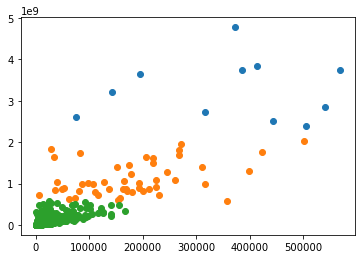

[[3.59640364e+05 3.27247774e+09]
 [1.78023286e+05 1.11848820e+09]
 [1.01802173e+04 3.61179095e+07]]


In [66]:
#groups = [(20, 20, "grupo1"), (300, 40, "grupo2"), (200, 200, "grupo3")]
#df = generate_df(groups, 50)
scatter_group_by("images/clusters.png", df, "Usuarios", "Consumo", "gdh")
list_t = [
    (np.array(tuples[0:2]), tuples[2])
    for tuples in df.itertuples(index=False, name=None)
]
points = [point for point, _ in list_t]
labels = [label for _, label in list_t]
# np.random.seed(0)
kn = k_means(
    points,
    3,
)
print(kn)